In [194]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [195]:
# Read Excel file and save as DataFrame

df = pd.read_excel('./Datasets/tobacco_data.xlsx')
df.columns = df.iloc[0]
df = df[1:]
df.head()

,Intervention_descriptor,tax_increase,outlet_reduction,dec_smoking_prevalence,dec_tobacco_supply,dec_smoking_uptake,age,gender,ethnicity,discount_rate,evidence_strength,qalys_pc,hs_costs_pc
1,Combined tobacco endgame strategy (tobacco-fre...,10,90,7,0,0,0-14,Male,non-Māori,0,NaN,40.865526,-1284765.096725
2,Combined tobacco endgame strategy (tobacco-fre...,10,90,7,0,0,15-24,Male,non-Māori,0,NaN,41.708939,-1270055.987675
3,Combined tobacco endgame strategy (tobacco-fre...,10,90,7,0,0,25-44,Male,non-Māori,0,NaN,13.282615,-318700.524314
4,Combined tobacco endgame strategy (tobacco-fre...,10,90,1,0,0,45-64,Male,non-Māori,0,NaN,7.222291,-119003.652181
5,Combined tobacco endgame strategy (tobacco-fre...,10,90,0.5,0,0,65+,Male,non-Māori,0,NaN,1.111505,-9656.694651


In [196]:
# Transform data

# Map age group to integer
age_group_mapping = {
    '0-14': 0,
    '15-24': 1,
    '25-44': 2,
    '45-64': 3,
    '65+': 4
}

# Map gender to integer
gender_mapping = {
    'Male': 0,
    'Female': 1
}

# Map ethnicity to integer
ethnicity_mapping = {
    'Māori': 0,
    'non-Māori': 1
}

# Apply the mapping to the 'Age_Group' column
df['age_group'] = df['age'].map(age_group_mapping)
df['gender_idx'] = df['gender'].map(gender_mapping)
df['ethnicity_idx'] = df['ethnicity'].map(ethnicity_mapping)

# Display the updated DataFrame
df.head()

,Intervention_descriptor,tax_increase,outlet_reduction,dec_smoking_prevalence,dec_tobacco_supply,dec_smoking_uptake,age,gender,ethnicity,discount_rate,evidence_strength,qalys_pc,hs_costs_pc,age_group,gender_idx,ethnicity_idx
1,Combined tobacco endgame strategy (tobacco-fre...,10,90,7,0,0,0-14,Male,non-Māori,0,NaN,40.865526,-1284765.096725,0.0,0.0,1.0
2,Combined tobacco endgame strategy (tobacco-fre...,10,90,7,0,0,15-24,Male,non-Māori,0,NaN,41.708939,-1270055.987675,1.0,0.0,1.0
3,Combined tobacco endgame strategy (tobacco-fre...,10,90,7,0,0,25-44,Male,non-Māori,0,NaN,13.282615,-318700.524314,2.0,0.0,1.0
4,Combined tobacco endgame strategy (tobacco-fre...,10,90,1,0,0,45-64,Male,non-Māori,0,NaN,7.222291,-119003.652181,3.0,0.0,1.0
5,Combined tobacco endgame strategy (tobacco-fre...,10,90,0.5,0,0,65+,Male,non-Māori,0,NaN,1.111505,-9656.694651,4.0,0.0,1.0


In [197]:
# Duplicate the DataFrame 5 times and randomise order
df_duplicated = pd.concat([df] * 5, ignore_index=True)

# Define dependent and independent variables
X = np.array(df_duplicated[['tax_increase', 'outlet_reduction', 'dec_smoking_prevalence', 'dec_tobacco_supply', 'dec_smoking_uptake', 'age_group', 'gender_idx', 'ethnicity_idx']])
y = np.array(df_duplicated[['qalys_pc','hs_costs_pc']])

In [198]:
# Split the dataset to 80% 
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Second split: 10% validation, 10% testing (from the 20% temp set)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# List of different values of n_estimators to test
n_estimators_list = [10, 25, 50, 100, 200, 300, 500]

# Dictionary to store MSE for different n_estimators values
mse_qalys_dict = {}
mse_costs_dict = {}

# Loop over the values of n_estimators
for n_estimators in n_estimators_list:
    # Initialize the RandomForestRegressor with the current n_estimators
    rf = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
    
    # Train the model on the training data
    rf.fit(X_train, y_train)
    
    # Make predictions on the validation set
    y_val_pred = rf.predict(X_val)
    
    # Compute MSE for each output separately on the validation set
    mse_qaly = mean_squared_error(y_val[:, 0], y_val_pred[:, 0])
    mse_cost = mean_squared_error(y_val[:, 1], y_val_pred[:, 1])
    
    # Store the average MSE for the validation set
    mse_qalys_dict[n_estimators] = mse_qaly
    mse_costs_dict[n_estimators] = mse_cost

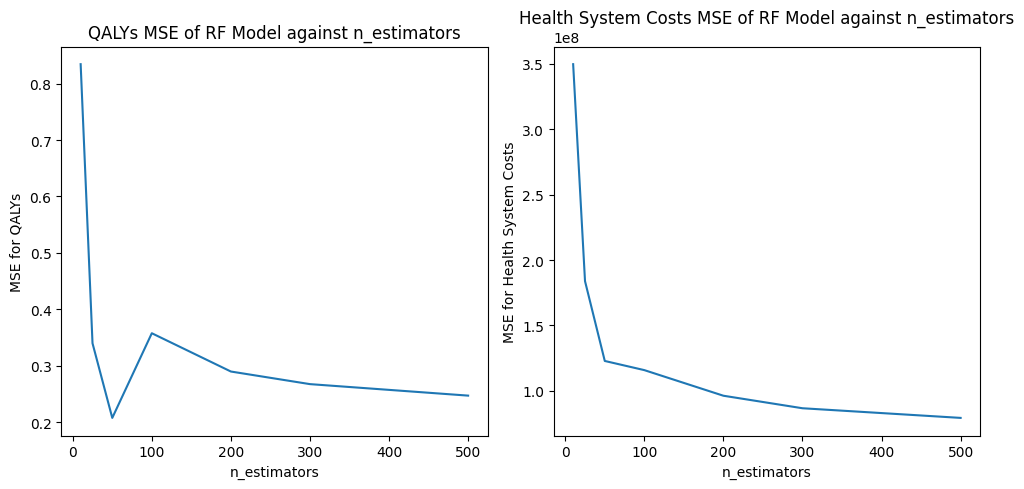

In [200]:
# Plot validation result
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Subplot for QALYs
ax1.plot(list(mse_qalys_dict.keys()), list(mse_qalys_dict.values()))
ax1.set_title('QALYs MSE of RF Model against n_estimators')
ax1.set_xlabel('n_estimators')
ax1.set_ylabel('MSE for QALYs')
ax1.set_xticks(range(0, 501, 100))  # Label x-axis every 50 units

# Subplot for Health System Cost
ax2.plot(list(mse_costs_dict.keys()), list(mse_costs_dict.values()))
ax2.set_title('Health System Costs MSE of RF Model against n_estimators')
ax2.set_xlabel('n_estimators')
ax2.set_ylabel('MSE for Health System Costs')
ax2.set_xticks(range(0, 501, 100))  # Label x-axis every 50 units

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

In [201]:
# List of different values of max_depth to test
max_depths_list = [10, 15, 20, 30, 50]

# Dictionary to store MSE for different n_estimators values
mse_qalys_dict_depth = {}
mse_costs_dict_depth = {}

# Loop over the values of max_depth
for max_depth in max_depths_list:
    # Initialize the RandomForestRegressor with the current max_depth
    rf = RandomForestRegressor(n_estimators=50, max_depth=max_depth, random_state=42)
    
    # Train the model on the training data
    rf.fit(X_train, y_train)
    
    # Make predictions on the validation set
    y_val_pred = rf.predict(X_val)
    
    # Compute MSE for each output separately on the validation set
    mse_qaly = mean_squared_error(y_val[:, 0], y_val_pred[:, 0])
    mse_cost = mean_squared_error(y_val[:, 1], y_val_pred[:, 1])
    
    # Store the average MSE for the validation set
    mse_qalys_dict_depth[max_depth] = mse_qaly
    mse_costs_dict_depth[max_depth] = mse_cost

In [ ]:
# Plot validation result
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Subplot for QALYs
ax1.plot(list(mse_qalys_dict_depth.keys()), list(mse_qalys_dict_depth.values()))
ax1.set_title('QALYs MSE of RF Model against max_depth')
ax1.set_xlabel('max_depth')
ax1.set_ylabel('MSE for QALYs')
ax1.set_xticks(range(10, 51, 5))  # Label x-axis every 50 units

# Subplot for Health System Cost
ax2.plot(list(mse_costs_dict_depth.keys()), list(mse_costs_dict_depth.values()))
ax2.set_title('Health System Costs MSE of RF Model against max_depth')
ax2.set_xlabel('max_depth')
ax2.set_ylabel('MSE for Health System Costs')
ax2.set_xticks(range(10, 51, 5))  # Label x-axis every 50 units

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

In [192]:
# Testing using best n_estimators and max_depth
n_estimators = 50
max_depth = 15
rf_best = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
rf_best.fit(X_train, y_train)

# Make predictions on the test set
y_test_pred = rf_best.predict(X_test)

# Compute MSE for each output
mse_qalys_test = mean_squared_error(y_test[:, 0], y_test_pred[:, 0])
mse_costs_test = mean_squared_error(y_test[:, 1], y_test_pred[:, 1])

print(f'n_estimators = {n_estimators}')
print(f'max_depth = {max_depth}')
print(f'MSE for QALYs: {np.round(mse_qalys_test,2)}')
print(f'MSE for Health System Cost: {np.round(mse_costs_test,2)}')

n_estimators = 50
max_depth = 15
MSE for QALYs: 0.64
MSE for Health System Cost: 279077008.57


In [193]:
qaly_percentage_error = mse_qalys_test / (max(df['qalys_pc']) - min(df['qalys_pc'])) * 100
cost_percentage_error = mse_costs_test / (max(df['hs_costs_pc']) - min(df['hs_costs_pc'])) * 100

print(f'MSE as a percentage of QALYs range: {np.round(qaly_percentage_error,2)}%')
print(f'MSE as a percentage of Health System Costs range: {np.round(cost_percentage_error,2)}%')

MSE as a percentage of QALYs range: 0.23%
MSE as a percentage of Health System Costs range: 4288.07%
